In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/open-problems-single-cell-perturbations/multiome_train.parquet
/kaggle/input/open-problems-single-cell-perturbations/multiome_obs_meta.csv
/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv
/kaggle/input/open-problems-single-cell-perturbations/adata_train.parquet
/kaggle/input/open-problems-single-cell-perturbations/multiome_var_meta.csv
/kaggle/input/open-problems-single-cell-perturbations/adata_obs_meta.csv
/kaggle/input/open-problems-single-cell-perturbations/id_map.csv
/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet
/kaggle/input/open-problems-single-cell-perturbations/adata_excluded_ids.csv


In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-02-06 06:51:26.618266: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 06:51:26.618398: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 06:51:26.788875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
de_train =   pd.read_parquet("/kaggle/input/open-problems-single-cell-perturbations/de_train.parquet")
id_map = pd.read_csv("/kaggle/input/open-problems-single-cell-perturbations/id_map.csv")
sample_submission = pd.read_csv("/kaggle/input/open-problems-single-cell-perturbations/sample_submission.csv")

In [4]:
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [5]:
id_map


,id,cell_type,sm_name
0,0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,1,B cells,ABT-199 (GDC-0199)
2,2,B cells,ABT737
3,3,B cells,AMD-070 (hydrochloride)
4,4,B cells,AT 7867
...,...,...,...
250,250,Myeloid cells,Vandetanib
251,251,Myeloid cells,Vanoxerine
252,252,Myeloid cells,Vardenafil
253,253,Myeloid cells,Vorinostat


In [6]:
de_train[de_train["control"] == True]

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
104,B cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.942197,0.539713,-0.417087,0.391397,2.049071,...,-0.094318,-0.043478,-0.269027,0.484859,0.905045,0.277953,1.126481,0.432023,-2.508760,-0.354758
105,Myeloid cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.254567,0.244074,-28.552191,-0.377238,-0.731186,...,1.771915,-0.085585,0.010659,-1.890484,1.062484,-0.136040,-0.224016,-1.890099,-3.105304,-1.155821
106,NK cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,-0.161665,0.269009,-1.770091,-0.198444,0.954753,...,0.131425,-1.112697,-0.589313,-0.660929,0.016530,0.319136,0.299521,-0.383452,0.267828,-1.100267
107,T cells CD4+,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.000443,0.750020,-0.151077,-2.733638,-1.073863,...,-1.032259,-0.571065,0.346539,-0.338557,0.549544,-0.607941,-0.130692,-0.059547,-0.169427,-1.992270
108,T cells CD8+,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.103281,-0.281974,-0.187118,0.535779,1.201660,...,-0.288675,-0.156537,-0.555925,-0.564582,0.735246,-0.641172,0.272963,-0.482503,-0.498744,-0.097232
109,T regulatory cells,Dabrafenib,LSM-6303,CC(C)(C)c1nc(-c2cccc(NS(=O)(=O)c3c(F)cccc3F)c2...,True,0.679796,0.457679,2.576746,2.151973,2.649578,...,-1.295633,1.393517,0.098008,0.523280,0.871999,2.195867,1.880501,0.489364,-0.388891,-0.617592
275,B cells,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,2.225073,0.564347,-0.437639,-0.415907,0.307772,...,10.803264,3.292811,-0.051246,0.247855,-1.651776,-1.788311,-0.418805,3.396236,-0.567121,0.501423
276,Myeloid cells,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,3.519499,6.284255,-24.687990,0.004540,15.109208,...,0.635599,0.210030,-21.273505,1.190610,-0.486464,-1.040062,-8.310726,0.612581,7.826692,-0.917186
277,NK cells,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,1.181036,3.652341,-7.026508,-17.801989,-0.656651,...,4.361655,0.558856,-0.809408,0.265743,-0.056795,-0.019083,-0.140576,3.909364,-1.252862,-1.467913
278,T cells CD4+,Belinostat,LSM-43181,O=C(/C=C/c1cccc(S(=O)(=O)Nc2ccccc2)c1)NO,True,0.858771,3.672879,-3.525978,-13.130322,-2.264816,...,4.859433,4.253850,0.628184,0.332405,-6.780020,-2.497143,-0.868885,3.692675,0.128906,-0.583605


In [7]:
print(de_train['cell_type'].unique())
len(de_train['cell_type'].unique())

['NK cells' 'T cells CD4+' 'T cells CD8+' 'T regulatory cells' 'B cells'
 'Myeloid cells']


6

In [8]:
features_columns = ["cell_type", "sm_name"]
labels_columns=["cell_type","sm_name","sm_lincs_id","SMILES","control"]
labels = de_train.drop(columns=labels_columns)
features = pd.DataFrame(de_train, columns=features_columns)

In [9]:
labels

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,0.104720,-0.077524,-1.625596,-0.144545,0.143555,0.073229,-0.016823,0.101717,-0.005153,1.043629,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,0.915953,-0.884380,0.371834,-0.081677,-0.498266,0.203559,0.604656,0.498592,-0.317184,0.375550,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,-0.387721,-0.305378,0.567777,0.303895,-0.022653,-0.480681,0.467144,-0.293205,-0.005098,0.214918,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,0.232893,0.129029,0.336897,0.486946,0.767661,0.718590,-0.162145,0.157206,-3.654218,-0.212402,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,4.290652,-0.063864,-0.017443,-0.541154,0.570982,2.022829,0.600011,1.231275,0.236739,0.338703,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,-0.544709,0.282458,-0.431359,-0.364961,0.043123,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,-0.455549,0.188181,0.595734,-0.100299,0.786192,0.090954,0.169523,0.428297,0.106553,0.435088,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,0.338168,-0.109079,0.270182,-0.436586,-0.069476,-0.061539,0.002818,-0.027167,-0.383696,0.226289,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,-0.706087,-0.620919,-1.485381,0.059303,-0.032584,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


In [10]:
test_data = pd.DataFrame(id_map, columns=features_columns)
test_data

,cell_type,sm_name
0,B cells,5-(9-Isopropyl-8-methyl-2-morpholino-9H-purin-...
1,B cells,ABT-199 (GDC-0199)
2,B cells,ABT737
3,B cells,AMD-070 (hydrochloride)
4,B cells,AT 7867
...,...,...
250,Myeloid cells,Vandetanib
251,Myeloid cells,Vanoxerine
252,Myeloid cells,Vardenafil
253,Myeloid cells,Vorinostat


In [11]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of the encoder
encoder = OneHotEncoder()

# Fit the encoder on features
encoder.fit(features)

# Transform the features into one-hot encoded format
one_hot_encode_features = encoder.transform(features)

# Transform the test data(id_map)
one_hot_test = encoder.transform(test_data)

In [12]:
one_hot_encode_features.toarray().shape, one_hot_test.toarray().shape

((614, 152), (255, 152))

In [13]:
from sklearn.model_selection import train_test_split

# Split the data into 70% training, 15% validation, and 15% testing
X_train, X_temp, y_train, y_temp = train_test_split(one_hot_encode_features, labels.values, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [14]:
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (429, 152)
X_val shape: (92, 152)
X_test shape: (93, 152)
y_train shape: (429, 18211)
y_val shape: (92, 18211)
y_test shape: (93, 18211)


In [15]:
full_features = one_hot_encode_features.toarray()
full_labels = labels.values

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

def create_model_checkpoint(filepath, monitor='val_mae', save_best_only=True,
                            save_weights_only=True, mode='auto', verbose=0):
    """
    Create a ModelCheckpoint callback for saving the best model weights during training.

    Args:
        filepath (str): Filepath to save the best weights.
        monitor (str): Metric to monitor (e.g., 'val_loss' or 'val_mae').
        save_best_only (bool): Save only the best weights.
        save_weights_only (bool): Save only the model's weights, not the entire model.
        mode (str): One of {'auto', 'min', 'max'}. In 'min' mode, it saves when the monitored metric decreases.
        verbose (int): Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

    Returns:

        keras.callbacks.ModelCheckpoint: ModelCheckpoint callback.
    """
    checkpoint = ModelCheckpoint(
        filepath=filepath,
        monitor=monitor,
        save_best_only=save_best_only,
        save_weights_only=save_weights_only,
        mode=mode,
        verbose=verbose
    )
    return checkpoint

In [17]:
def plot_training_history(history, metrics):
    """
    Plot training history curves for loss and evaluation metrics on the same line.

    Args:
        history (keras.callbacks.History): Training history object.
        metrics (list): List of metric names to plot.

    Returns:
        None
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Training Loss', color="blue")
    plt.plot(epochs, val_loss, label='Validation Loss', color="red")
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot specified evaluation metrics on the same line
    for metric in metrics:
        train_metric_name = f'Training {metric.capitalize()}'
        val_metric_name = f'Validation {metric.capitalize()}'
        train_metric = history.history[metric]
        val_metric = history.history['val_' + metric]

        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_metric, label=train_metric_name, color="green")
        plt.plot(epochs, val_metric, label=val_metric_name, color="orange")

    plt.title('Metrics')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

In [18]:
from sklearn.metrics import mean_absolute_error

def calculate_mae_and_mrrmse(model, data, y_true):
    """
    Calculate Mean Absolute Error (MAE) and Mean Rowwise Root Mean Squared Error (MRRMSE).

    Parameters:
    - model: The trained  model.
    - data: The input data for prediction.
    - y_true: The true target values.
    - scaler: The scaler used for data normalization.

    Returns:
    - None
    """
    # Predict using the model
    y_pred_original = model.predict(data, batch_size=1)
    
    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true , y_pred_original)
    
    # Calculate Mean Rowwise Root Mean Squared Error (MRRMSE)
    rowwise_rmse = np.sqrt(np.mean(np.square(y_true - y_pred_original), axis=1))
    mrrmse_score = np.mean(rowwise_rmse)
    
    # Print the results
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Rowwise Root Mean Squared Error (MRRMSE): {mrrmse_score}")

In [19]:
def mean_rowwise_rmse_loss(y_true, y_pred):
    """
    Custom loss function to calculate the Mean Rowwise Root Mean Squared Error (RMSE) loss.

    Parameters:
    - y_true: The true target values.
    - y_pred: The predicted values.

    Returns:
    - Mean Rowwise RMSE loss as a scalar tensor.
    """
    # Calculate RMSE for each row
    rmse_per_row = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    # Calculate the mean of RMSE values across all rows
    mean_rmse = tf.reduce_mean(rmse_per_row)
    
    return mean_rmse

In [20]:
def custom_mean_rowwise_rmse(y_true, y_pred):
    """
    Custom metric to calculate the Mean Rowwise Root Mean Squared Error (RMSE).

    Parameters:
    - y_true: The true target values.
    - y_pred: The predicted values.

    Returns:
    - Mean Rowwise RMSE as a scalar tensor.
    """
    # Calculate RMSE for each row
    rmse_per_row = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=1))
    # Calculate the mean of RMSE values across all rows
    mean_rmse = tf.reduce_mean(rmse_per_row)
    
    return mean_rmse

In [21]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

In [22]:
tf.random.set_seed(42)

model_0 = Sequential([
    Dense(512, activation="tanh"),
    Dense(18211, activation="linear")
])

model_0.compile(loss=mean_rowwise_rmse_loss, 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[custom_mean_rowwise_rmse])

history_0 = model_0.fit(X_train, y_train,
                       epochs=10,
                       validation_data=(X_val,y_val),
                       batch_size=32,
                       callbacks=[create_model_checkpoint("model_0", monitor="val_custom_mean_rowwise_rmse")])

Epoch 1/10
14/14 [==============================] - 3s 158ms/step - loss: 1.3655 - custom_mean_rowwise_rmse: 1.3595 - val_loss: 0.8349 - val_custom_mean_rowwise_rmse: 0.8333
Epoch 2/10
14/14 [==============================] - 2s 147ms/step - loss: 1.3458 - custom_mean_rowwise_rmse: 1.3219 - val_loss: 0.8209 - val_custom_mean_rowwise_rmse: 0.8189
Epoch 3/10
14/14 [==============================] - 2s 147ms/step - loss: 1.3280 - custom_mean_rowwise_rmse: 1.3070 - val_loss: 0.8183 - val_custom_mean_rowwise_rmse: 0.8160
Epoch 4/10
14/14 [==============================] - 2s 143ms/step - loss: 1.3145 - custom_mean_rowwise_rmse: 1.2896 - val_loss: 0.8175 - val_custom_mean_rowwise_rmse: 0.8151
Epoch 5/10
14/14 [==============================] - 2s 128ms/step - loss: 1.3026 - custom_mean_rowwise_rmse: 1.3144 - val_loss: 0.8180 - val_custom_mean_rowwise_rmse: 0.8155
Epoch 6/10
14/14 [==============================] - 2s 125ms/step - loss: 1.2908 - custom_mean_rowwise_rmse: 1.2713 - val_loss: 0.

In [23]:
model_0.load_weights("model_0")
calculate_mae_and_mrrmse(model=model_0, data=X_test, y_true=y_test)

93/93 [==============================] - 0s 4ms/step
Mean Absolute Error (MAE): 0.8157054430294234
Mean Rowwise Root Mean Squared Error (MRRMSE): 1.2749735476813384


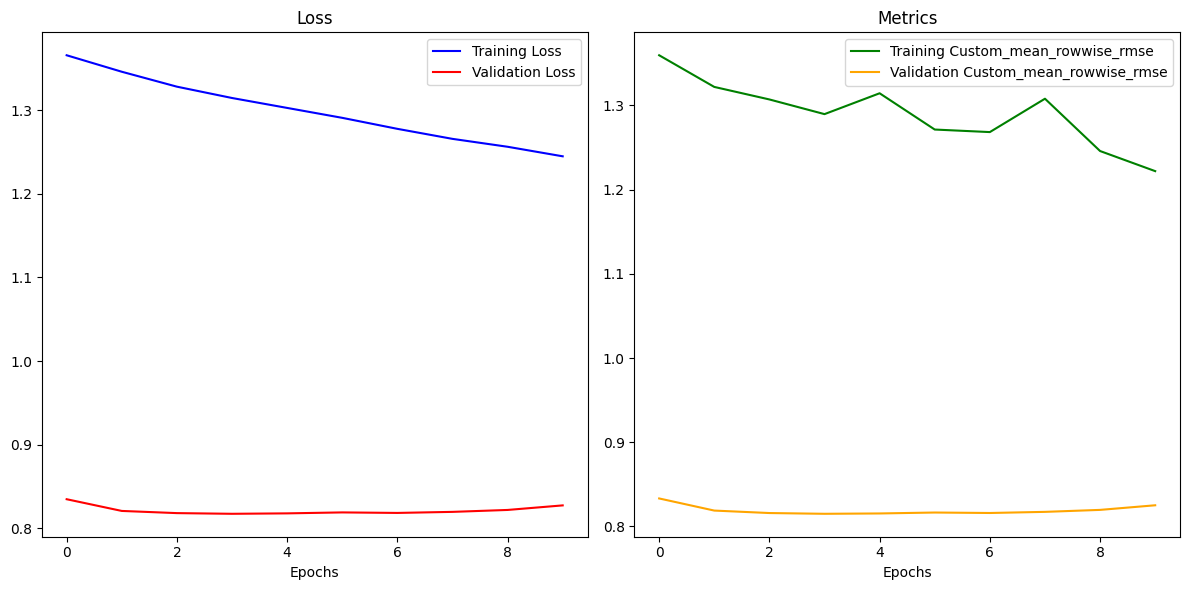

In [24]:
plot_training_history(history_0, metrics=["custom_mean_rowwise_rmse"])